# Strategy : EMA (Exponential Moving Avarage) Crossover 9/21

In [1]:
#Since accessing historical data through the Zerodha Kite Connect API requires a paid subscription, 
#I have utilized the yfinance library to fetch historical market data and implement the trading strategy through it .

In [2]:
# =============================================================================
# Import Libraries and Setup
# =============================================================================

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quantstats as qs
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

qs.extend_pandas()
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
# =============================================================================
#  Define Stock Selection and Parameters
# =============================================================================

# Diversified NIFTY50 stocks across sectors
STOCKS = [
    'RELIANCE.NS',    # Oil & Gas
    'TCS.NS',         # IT Services
    'HDFCBANK.NS',    # Banking
    'INFY.NS',        # IT Services
    'ICICIBANK.NS',   # Banking
    'HINDUNILVR.NS',  # FMCG
    'ITC.NS',         # FMCG
    'SBIN.NS',        # Banking
    'BHARTIARTL.NS',  # Telecom
    'ASIANPAINT.NS'   # Paints
]

# Strategy parameters
INITIAL_CAPITAL = 100000  # 1,00,000 per stock
EMA_SHORT = 9
EMA_LONG = 21
START_DATE = (datetime.now() - timedelta(days=3*365)).strftime('%Y-%m-%d')
END_DATE = datetime.now().strftime('%Y-%m-%d')

print(f"Selected stocks: {[stock.replace('.NS', '') for stock in STOCKS]}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Capital allocation: ₹{INITIAL_CAPITAL:,} per stock")

Selected stocks: ['RELIANCE', 'TCS', 'HDFCBANK', 'INFY', 'ICICIBANK', 'HINDUNILVR', 'ITC', 'SBIN', 'BHARTIARTL', 'ASIANPAINT']
Date range: 2022-07-14 to 2025-07-13
Capital allocation: ₹100,000 per stock


In [4]:
# =============================================================================
# Data Fetching Function
# =============================================================================

def fetch_stock_data(symbols, start_date, end_date):
    """
    Fetch historical stock data for given symbols
    """
    stock_data = {}
    failed_stocks = []
    
    for symbol in symbols:
        try:
            print(f"Fetching data for {symbol}...")
            ticker = yf.Ticker(symbol)
            data = ticker.history(start=start_date, end=end_date)
            
            if not data.empty:
                stock_data[symbol] = data
                print(f"✓ {symbol}: {len(data)} records fetched")
            else:
                failed_stocks.append(symbol)
                print(f"✗ {symbol}: No data found")
                
        except Exception as e:
            failed_stocks.append(symbol)
            print(f"✗ {symbol}: Error - {str(e)}")
    
    if failed_stocks:
        print(f"\nFailed to fetch: {failed_stocks}")
    
    return stock_data

# Fetch data
print("Fetching historical data...")
stock_data = fetch_stock_data(STOCKS, START_DATE, END_DATE)
print(f"\nSuccessfully fetched data for {len(stock_data)} stocks")

Fetching historical data...
Fetching data for RELIANCE.NS...
✓ RELIANCE.NS: 739 records fetched
Fetching data for TCS.NS...
✓ TCS.NS: 739 records fetched
Fetching data for HDFCBANK.NS...
✓ HDFCBANK.NS: 739 records fetched
Fetching data for INFY.NS...
✓ INFY.NS: 739 records fetched
Fetching data for ICICIBANK.NS...
✓ ICICIBANK.NS: 739 records fetched
Fetching data for HINDUNILVR.NS...
✓ HINDUNILVR.NS: 739 records fetched
Fetching data for ITC.NS...
✓ ITC.NS: 739 records fetched
Fetching data for SBIN.NS...
✓ SBIN.NS: 739 records fetched
Fetching data for BHARTIARTL.NS...
✓ BHARTIARTL.NS: 739 records fetched
Fetching data for ASIANPAINT.NS...
✓ ASIANPAINT.NS: 739 records fetched

Successfully fetched data for 10 stocks


In [7]:
# =============================================================================
#  EMA Calculation and Signal Generation
# =============================================================================

def calculate_ema_signals(data, short_window=9, long_window=21):
    """
    Calculate EMA crossover signals
    """
    df = data.copy()
    
    # Calculate EMAs
    df[f'EMA_{short_window}'] = df['Close'].ewm(span=short_window).mean()
    df[f'EMA_{long_window}'] = df['Close'].ewm(span=long_window).mean()
    
    # Generate signals
    df['Signal'] = 0
    df['Signal'][short_window:] = np.where(
        df[f'EMA_{short_window}'][short_window:] > df[f'EMA_{long_window}'][short_window:], 1, 0
    )
    
    # Generate trading positions
    df['Position'] = df['Signal'].diff()
    
    # Mark buy/sell points
    df['Buy'] = np.where(df['Position'] == 1, df['Close'], np.nan)
    df['Sell'] = np.where(df['Position'] == -1, df['Close'], np.nan)
    
    return df

# Calculate signals for all stocks
stock_signals = {}
for symbol, data in stock_data.items():
    stock_signals[symbol] = calculate_ema_signals(data, EMA_SHORT, EMA_LONG)
    print(f"✓ Signals calculated for {symbol}")

print(f"\nSignals calculated for {len(stock_signals)} stocks")

✓ Signals calculated for RELIANCE.NS
✓ Signals calculated for TCS.NS
✓ Signals calculated for HDFCBANK.NS
✓ Signals calculated for INFY.NS
✓ Signals calculated for ICICIBANK.NS
✓ Signals calculated for HINDUNILVR.NS
✓ Signals calculated for ITC.NS
✓ Signals calculated for SBIN.NS
✓ Signals calculated for BHARTIARTL.NS
✓ Signals calculated for ASIANPAINT.NS

Signals calculated for 10 stocks


In [8]:
# =============================================================================
#  Backtesting Function
# =============================================================================

def backtest_strategy(data, initial_capital=100000):
    """
    Backtest the EMA crossover strategy
    """
    df = data.copy()
    capital = initial_capital
    shares = 0
    portfolio_value = []
    trade_log = []
    
    for i in range(len(df)):
        current_price = df['Close'].iloc[i]
        
        # Buy signal
        if df['Position'].iloc[i] == 1 and shares == 0:
            shares = capital / current_price
            capital = 0
            trade_log.append({
                'Date': df.index[i],
                'Action': 'BUY',
                'Price': current_price,
                'Shares': shares,
                'Value': shares * current_price
            })
        
        # Sell signal
        elif df['Position'].iloc[i] == -1 and shares > 0:
            capital = shares * current_price
            trade_log.append({
                'Date': df.index[i],
                'Action': 'SELL',
                'Price': current_price,
                'Shares': shares,
                'Value': capital
            })
            shares = 0
        
        # Calculate portfolio value
        if shares > 0:
            portfolio_value.append(shares * current_price)
        else:
            portfolio_value.append(capital)
    
    df['Portfolio_Value'] = portfolio_value
    df['Returns'] = df['Portfolio_Value'].pct_change()
    
    return df, pd.DataFrame(trade_log)

# Run backtests
backtest_results = {}
trade_logs = {}

for symbol, data in stock_signals.items():
    backtest_results[symbol], trade_logs[symbol] = backtest_strategy(data, INITIAL_CAPITAL)
    print(f"✓ Backtest completed for {symbol}")

✓ Backtest completed for RELIANCE.NS
✓ Backtest completed for TCS.NS
✓ Backtest completed for HDFCBANK.NS
✓ Backtest completed for INFY.NS
✓ Backtest completed for ICICIBANK.NS
✓ Backtest completed for HINDUNILVR.NS
✓ Backtest completed for ITC.NS
✓ Backtest completed for SBIN.NS
✓ Backtest completed for BHARTIARTL.NS
✓ Backtest completed for ASIANPAINT.NS


In [9]:
# =============================================================================
#  Visualization Function
# =============================================================================
def plot_strategy_chart(data, symbol, trade_log):
    """
    Plot price chart with EMA lines and buy/sell signals
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Price and EMA plot
    ax1.plot(data.index, data['Close'], label='Close Price', linewidth=1.5, alpha=0.7)
    ax1.plot(data.index, data[f'EMA_{EMA_SHORT}'], label=f'EMA {EMA_SHORT}', linewidth=1.2)
    ax1.plot(data.index, data[f'EMA_{EMA_LONG}'], label=f'EMA {EMA_LONG}', linewidth=1.2)
    
    # Buy/Sell signals
    buy_signals = data.dropna(subset=['Buy'])
    sell_signals = data.dropna(subset=['Sell'])
    
    ax1.scatter(buy_signals.index, buy_signals['Buy'], color='green', 
               marker='^', s=100, label='Buy Signal', zorder=5)
    ax1.scatter(sell_signals.index, sell_signals['Sell'], color='red', 
               marker='v', s=100, label='Sell Signal', zorder=5)
    
    ax1.set_title(f'{symbol.replace(".NS", "")} - EMA Crossover Strategy', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price (₹)', fontsize=12)
    ax1.legend(loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Portfolio value plot
    ax2.plot(data.index, data['Portfolio_Value'], label='Portfolio Value', 
             color='purple', linewidth=2)
    ax2.axhline(y=INITIAL_CAPITAL, color='red', linestyle='--', alpha=0.7, 
                label=f'Initial Capital (₹{INITIAL_CAPITAL:,})')
    
    ax2.set_title('Portfolio Value Over Time', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Portfolio Value (₹)', fontsize=12)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print trade summary
    if not trade_log.empty:
        print(f"\nTrade Summary for {symbol.replace('.NS', '')}:")
        print(f"Total Trades: {len(trade_log)}")
        print(f"Final Portfolio Value: ₹{data['Portfolio_Value'].iloc[-1]:,.2f}")
        print(f"Total Return: {((data['Portfolio_Value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100):.2f}%")
        print(f"Buy & Hold Return: {((data['Close'].iloc[-1] / data['Close'].iloc[0] - 1) * 100):.2f}%")

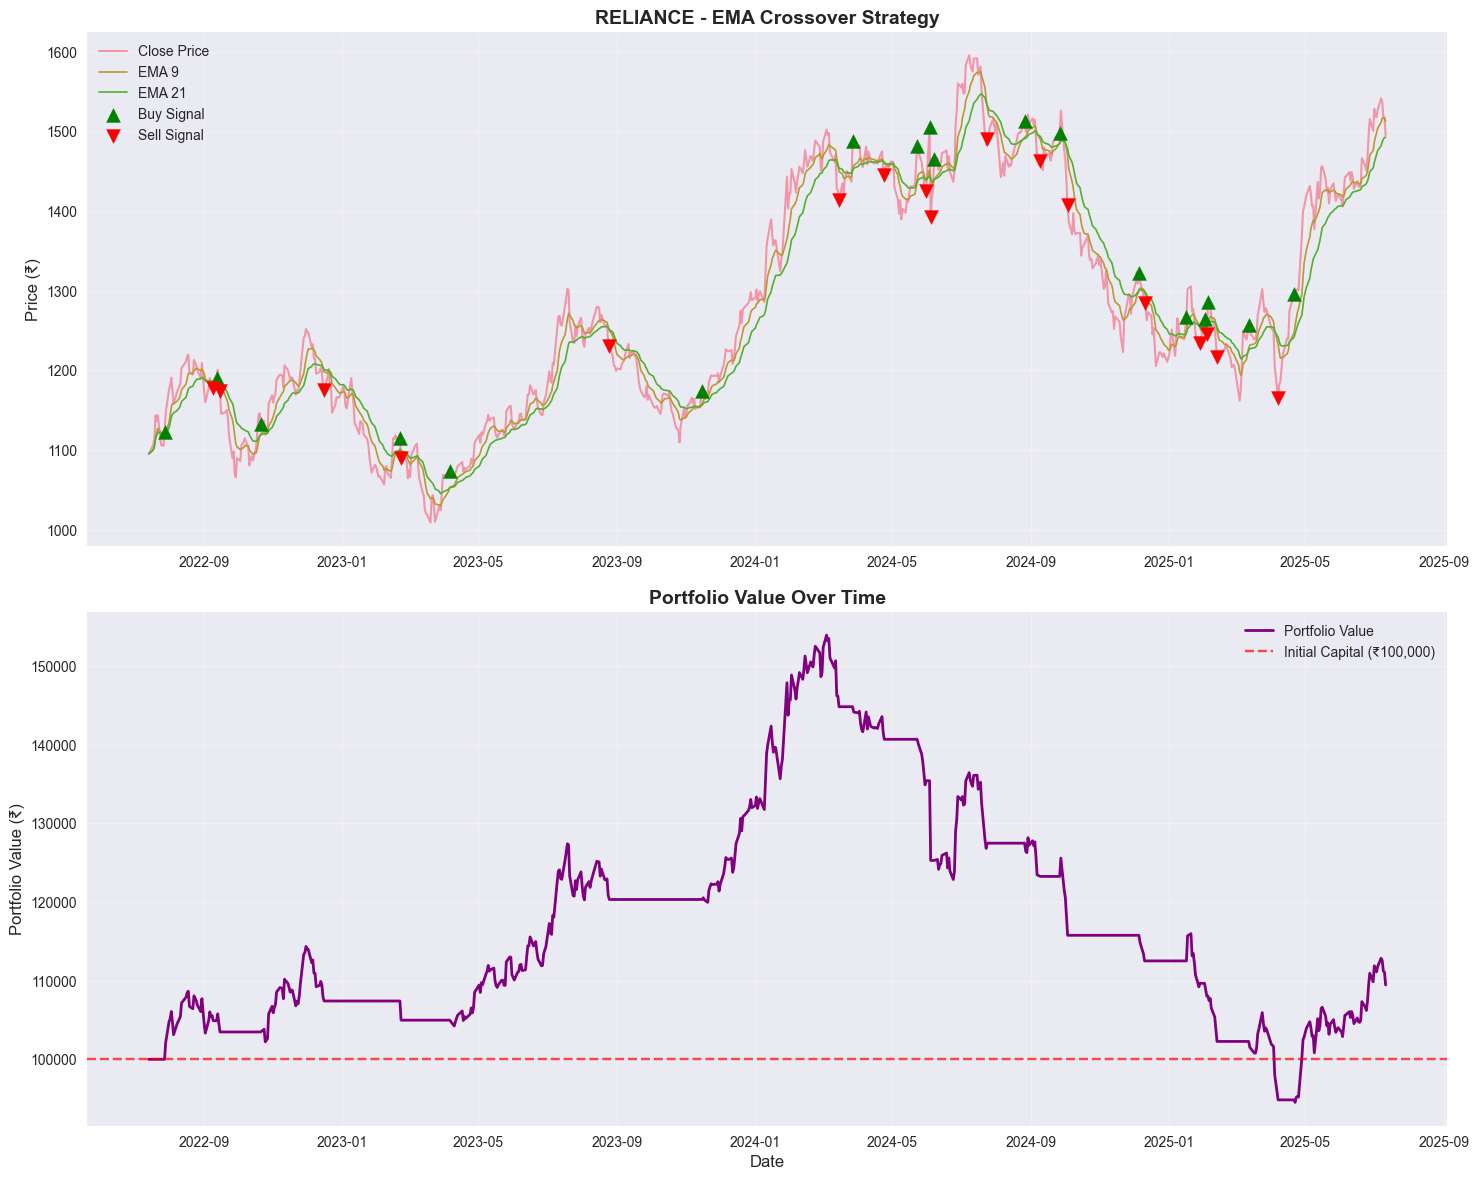


Trade Summary for RELIANCE:
Total Trades: 35
Final Portfolio Value: ₹109,461.06
Total Return: 9.46%
Buy & Hold Return: 36.54%


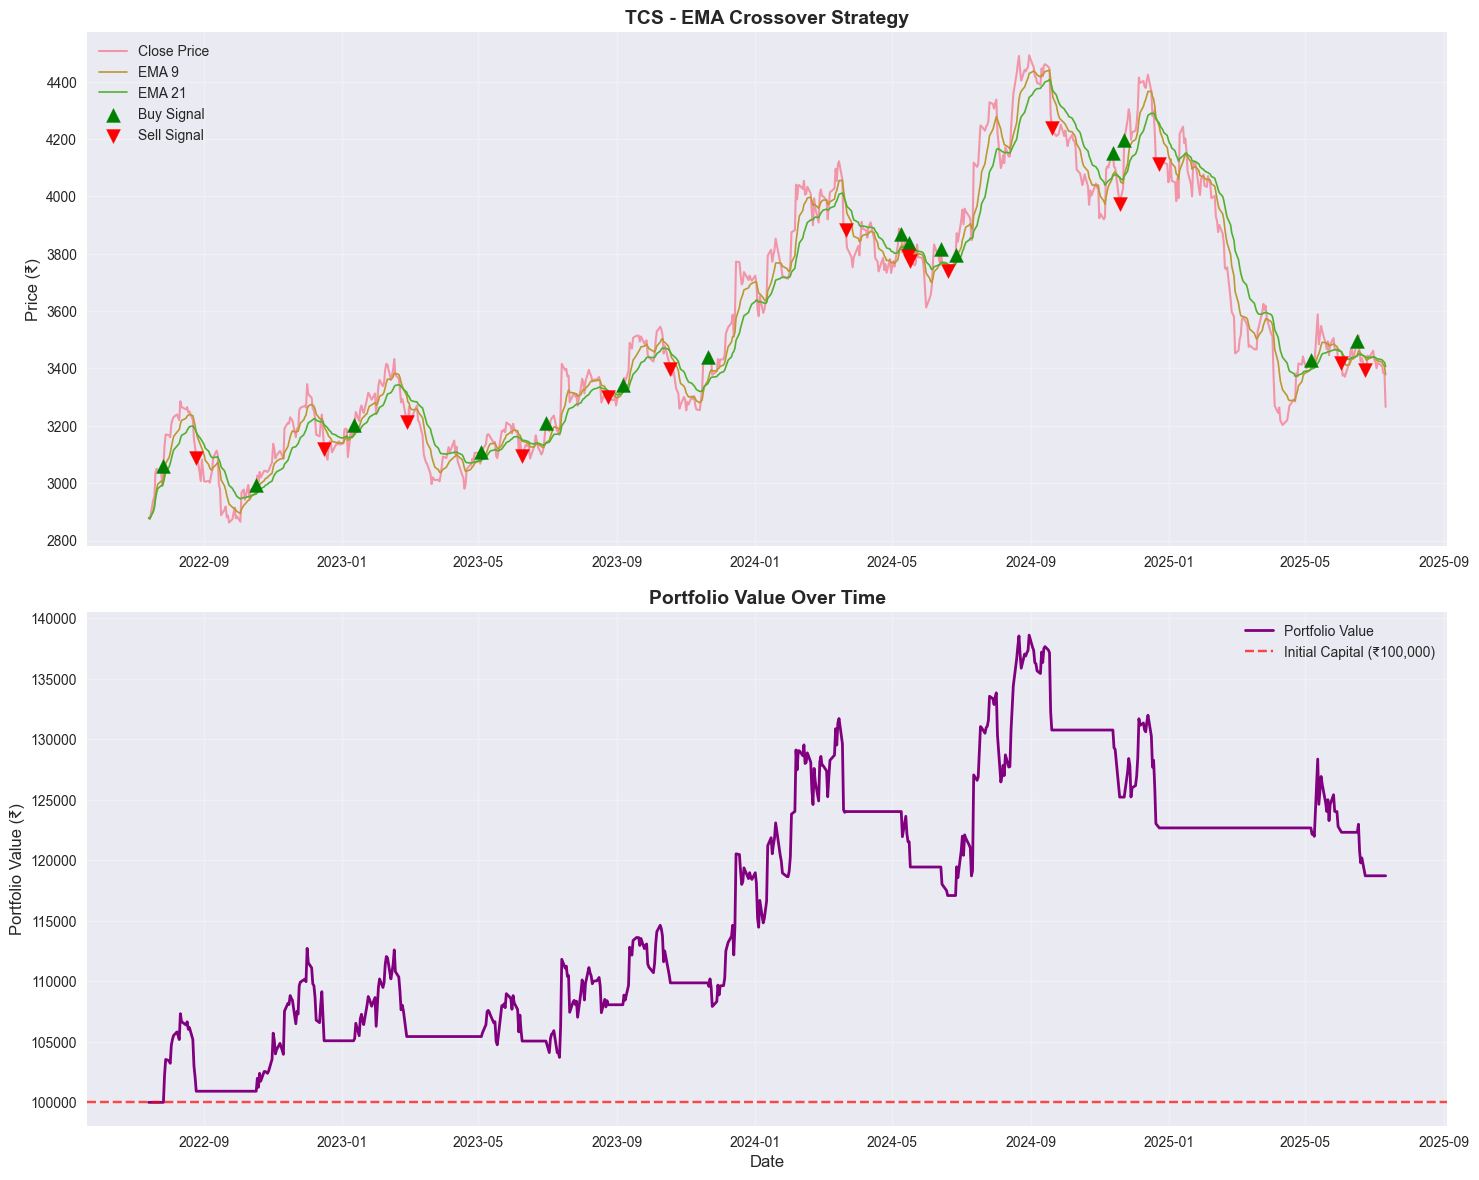


Trade Summary for TCS:
Total Trades: 30
Final Portfolio Value: ₹118,718.41
Total Return: 18.72%
Buy & Hold Return: 13.44%


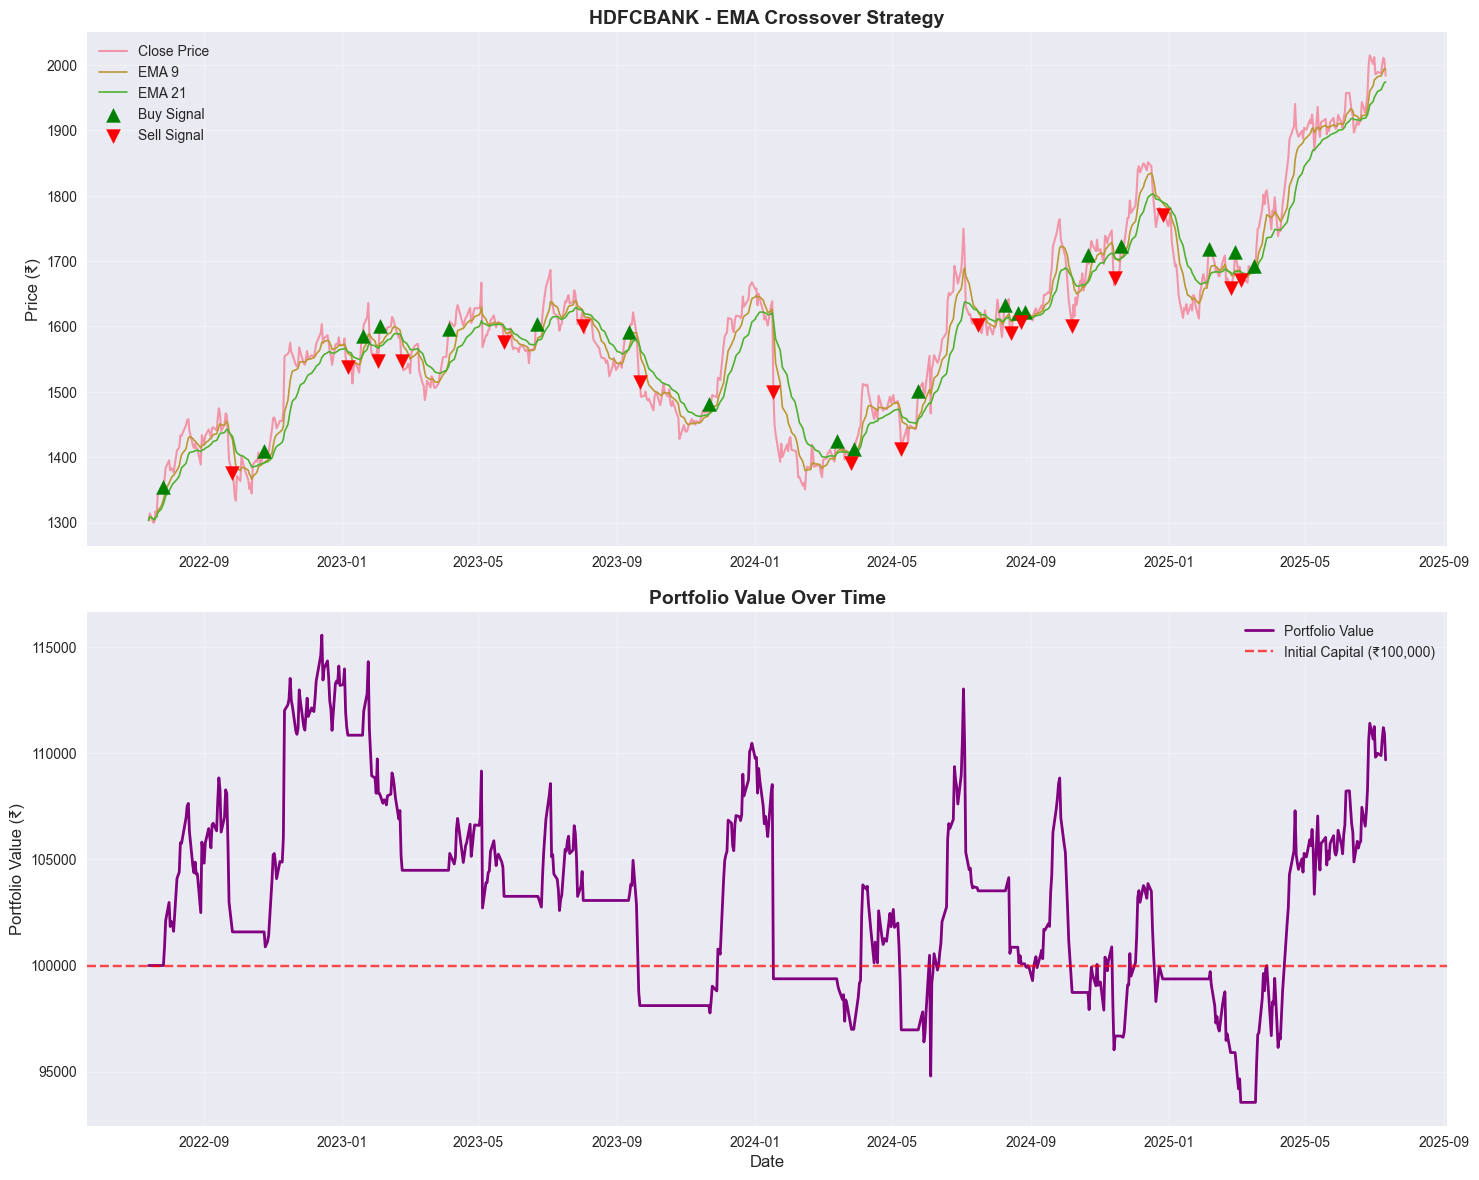


Trade Summary for HDFCBANK:
Total Trades: 37
Final Portfolio Value: ₹109,691.65
Total Return: 9.69%
Buy & Hold Return: 52.19%


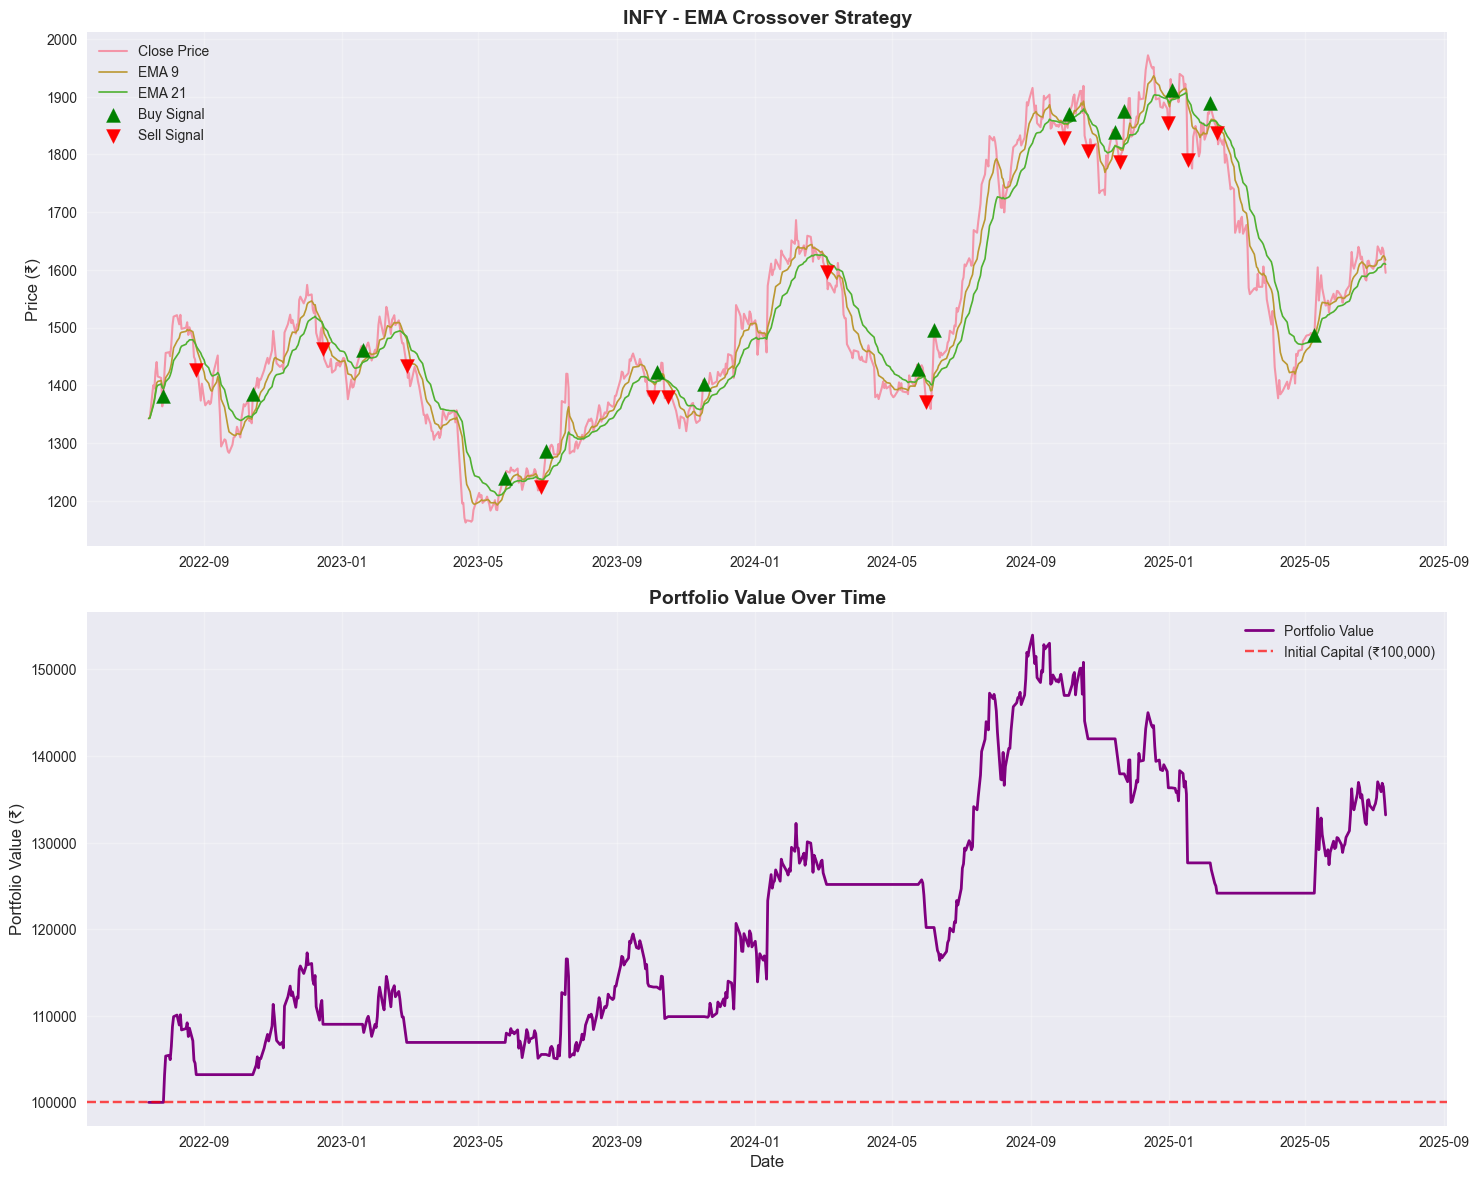


Trade Summary for INFY:
Total Trades: 29
Final Portfolio Value: ₹133,198.70
Total Return: 33.20%
Buy & Hold Return: 18.81%


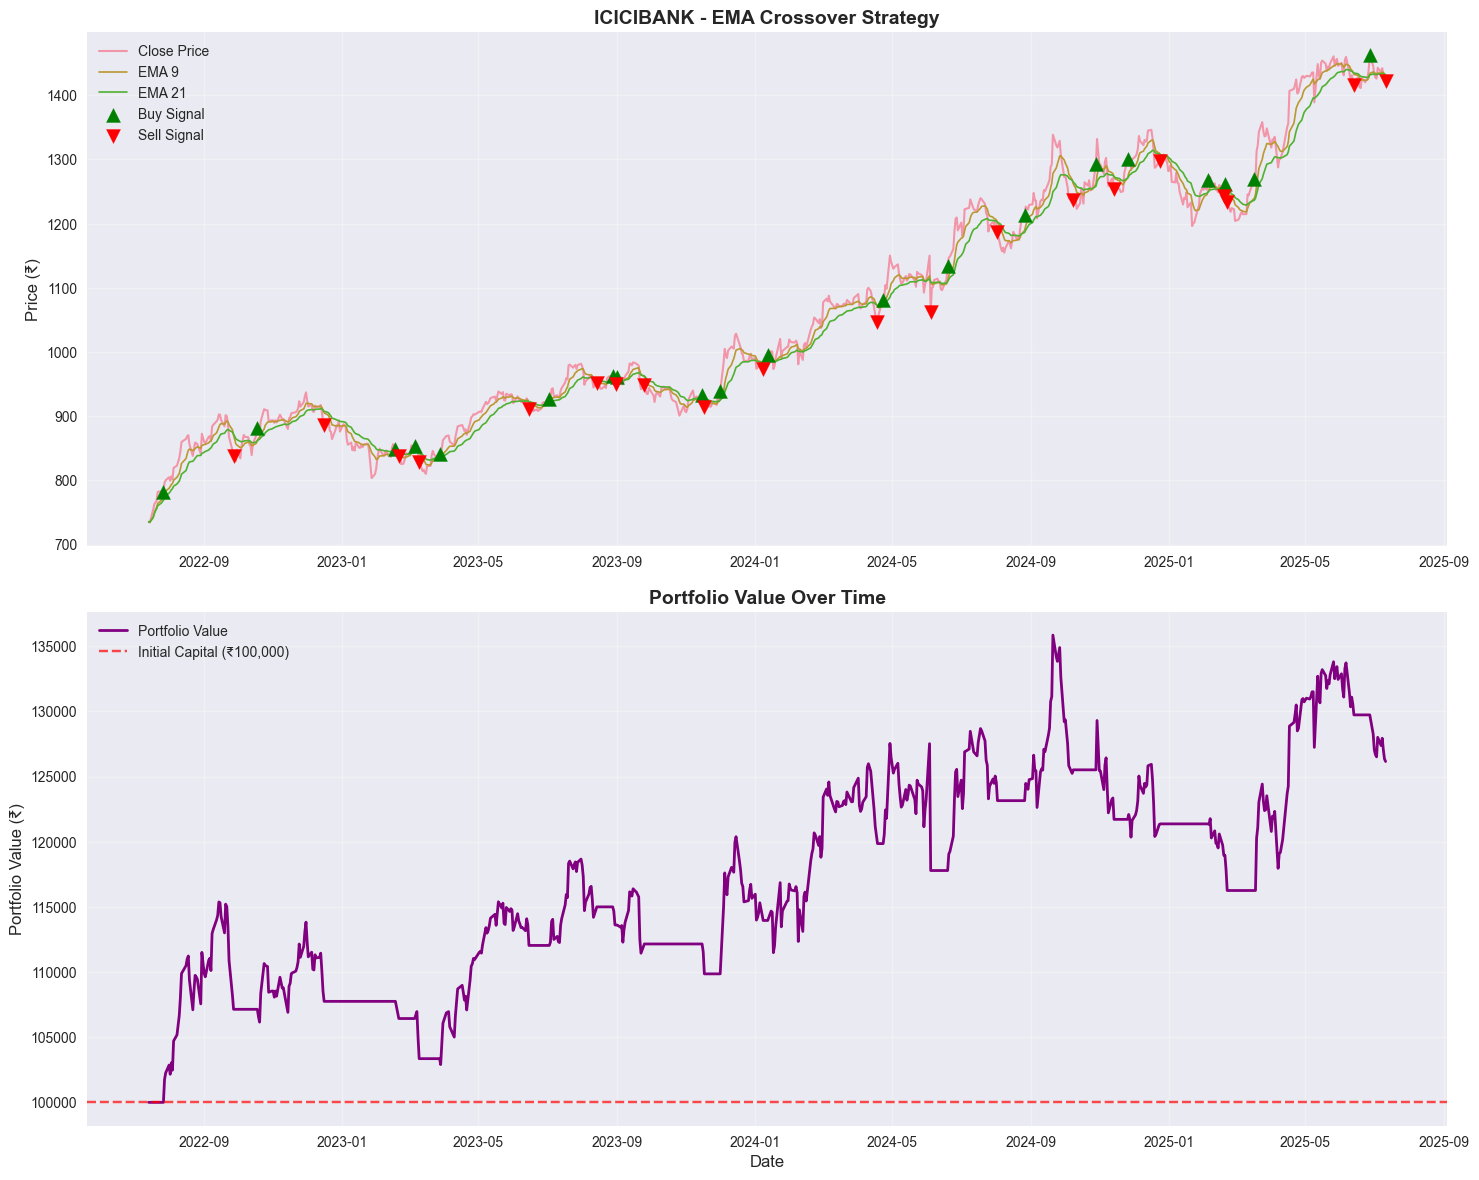


Trade Summary for ICICIBANK:
Total Trades: 40
Final Portfolio Value: ₹126,158.03
Total Return: 26.16%
Buy & Hold Return: 93.33%


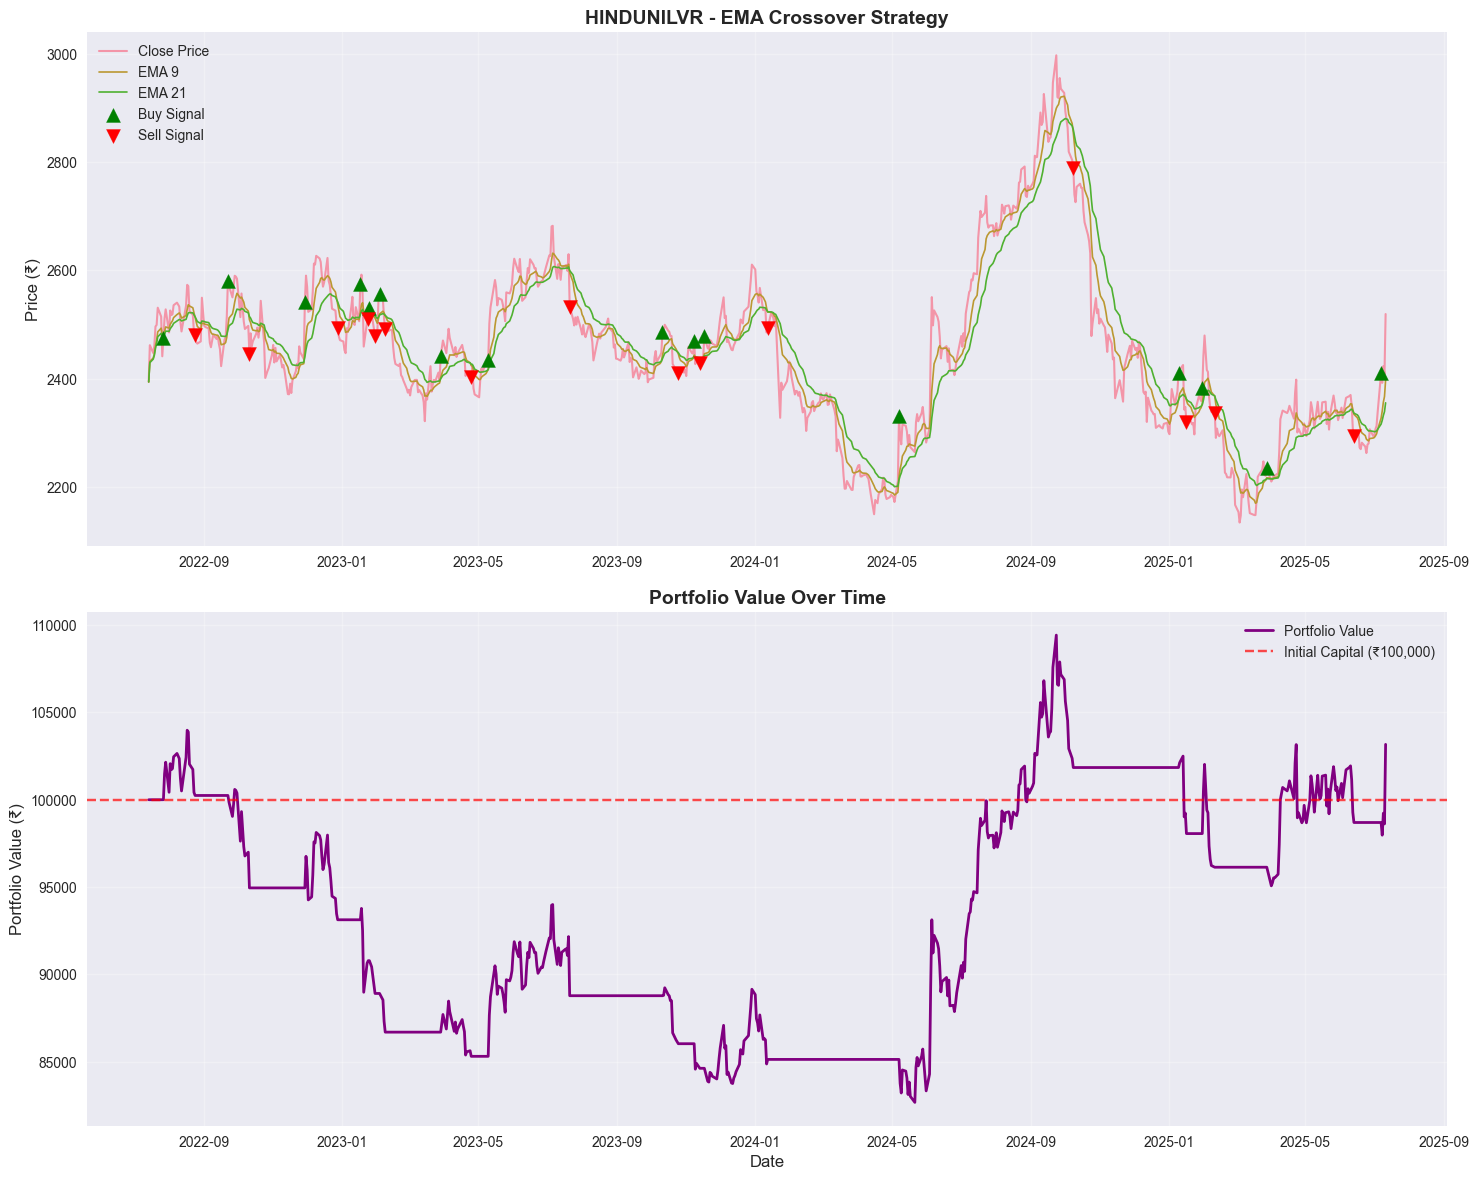


Trade Summary for HINDUNILVR:
Total Trades: 31
Final Portfolio Value: ₹103,168.60
Total Return: 3.17%
Buy & Hold Return: 5.23%


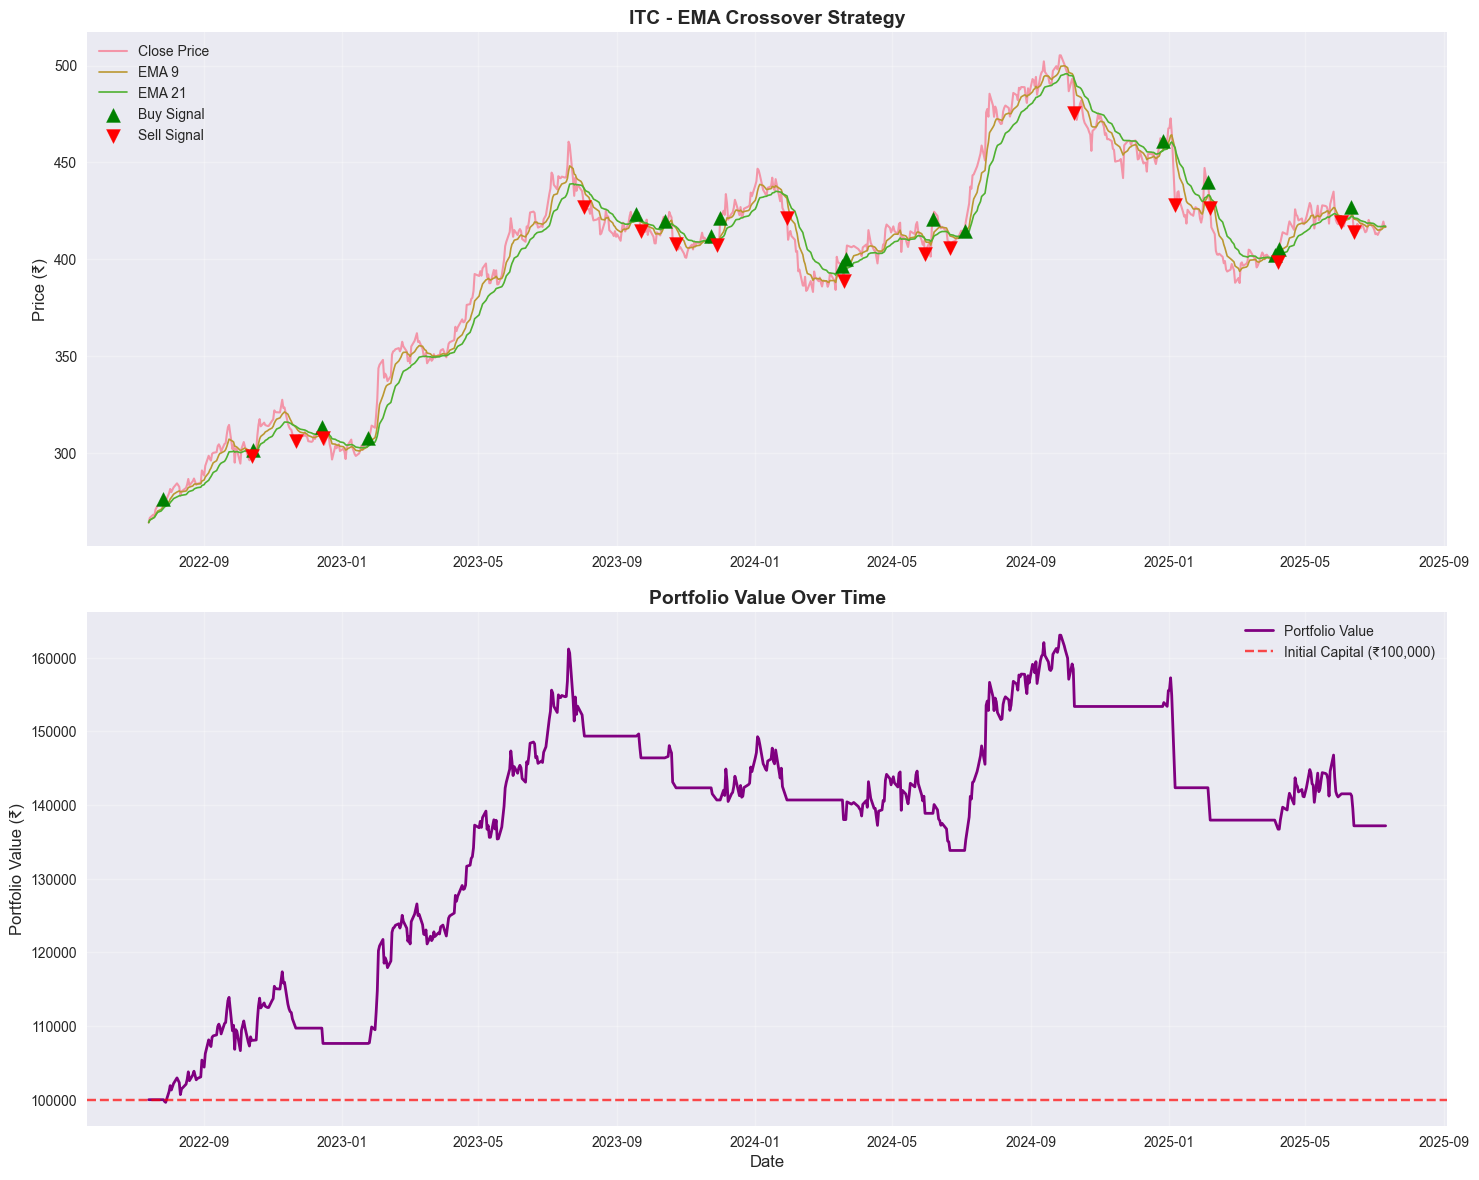


Trade Summary for ITC:
Total Trades: 34
Final Portfolio Value: ₹137,172.69
Total Return: 37.17%
Buy & Hold Return: 57.88%


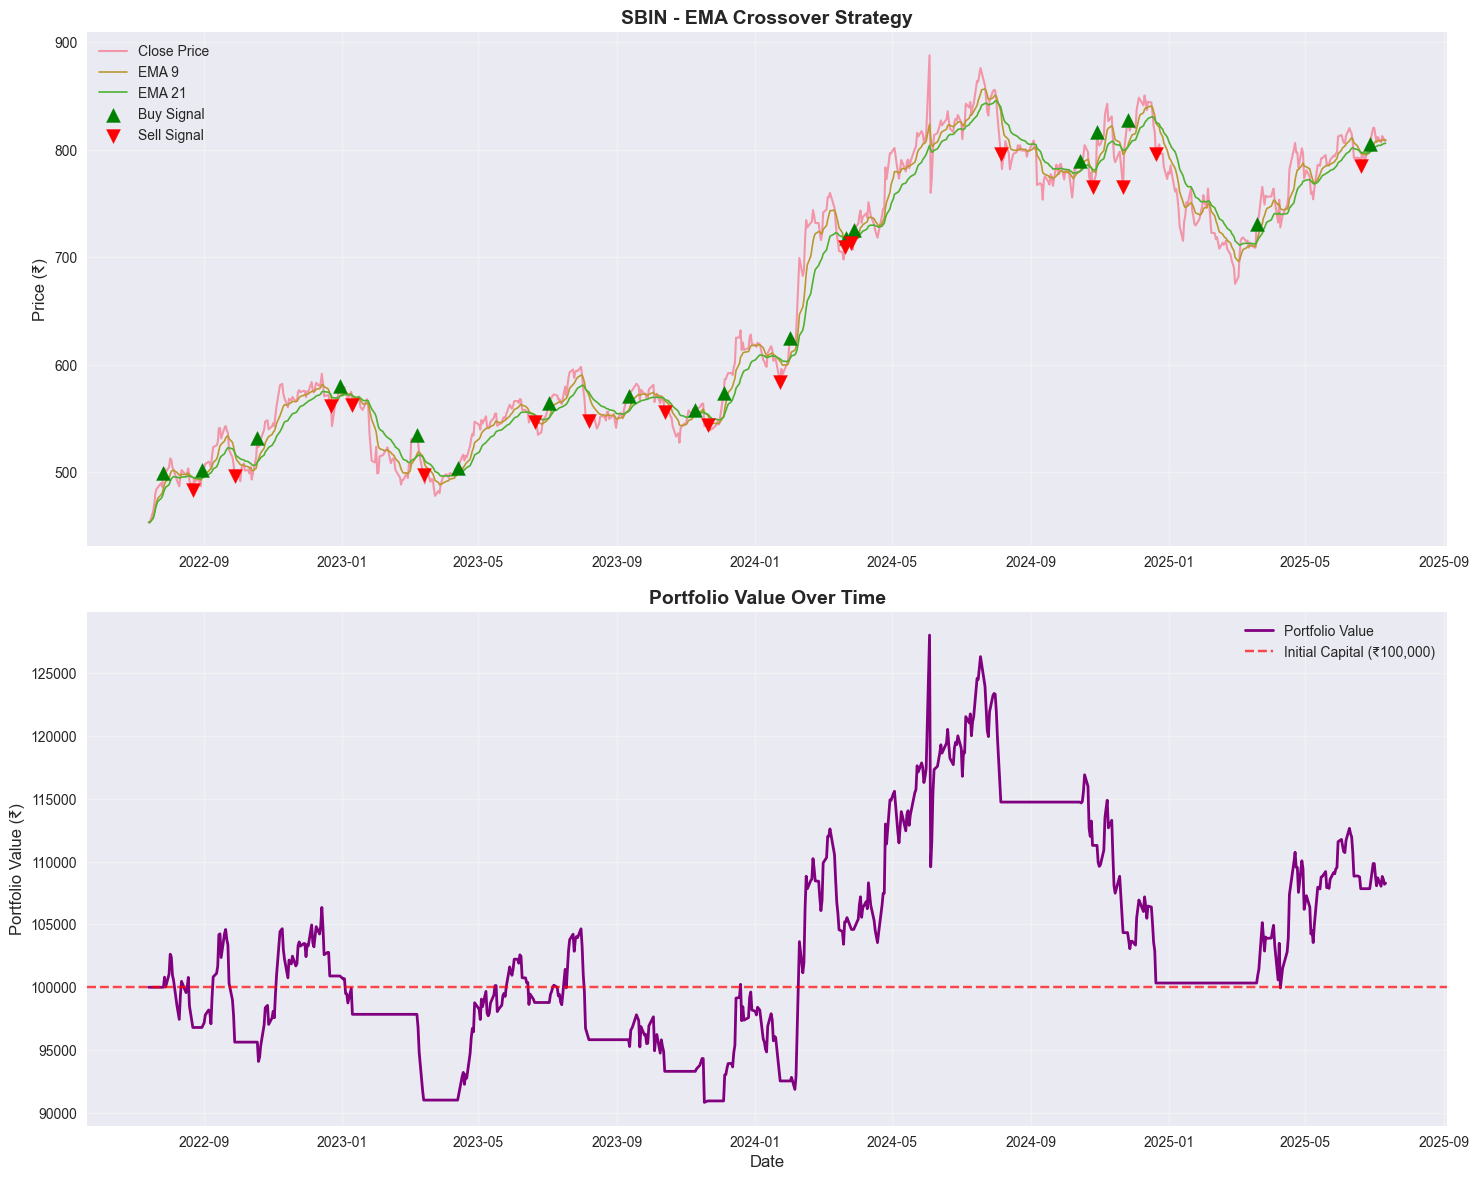


Trade Summary for SBIN:
Total Trades: 35
Final Portfolio Value: ₹108,283.01
Total Return: 8.28%
Buy & Hold Return: 78.37%


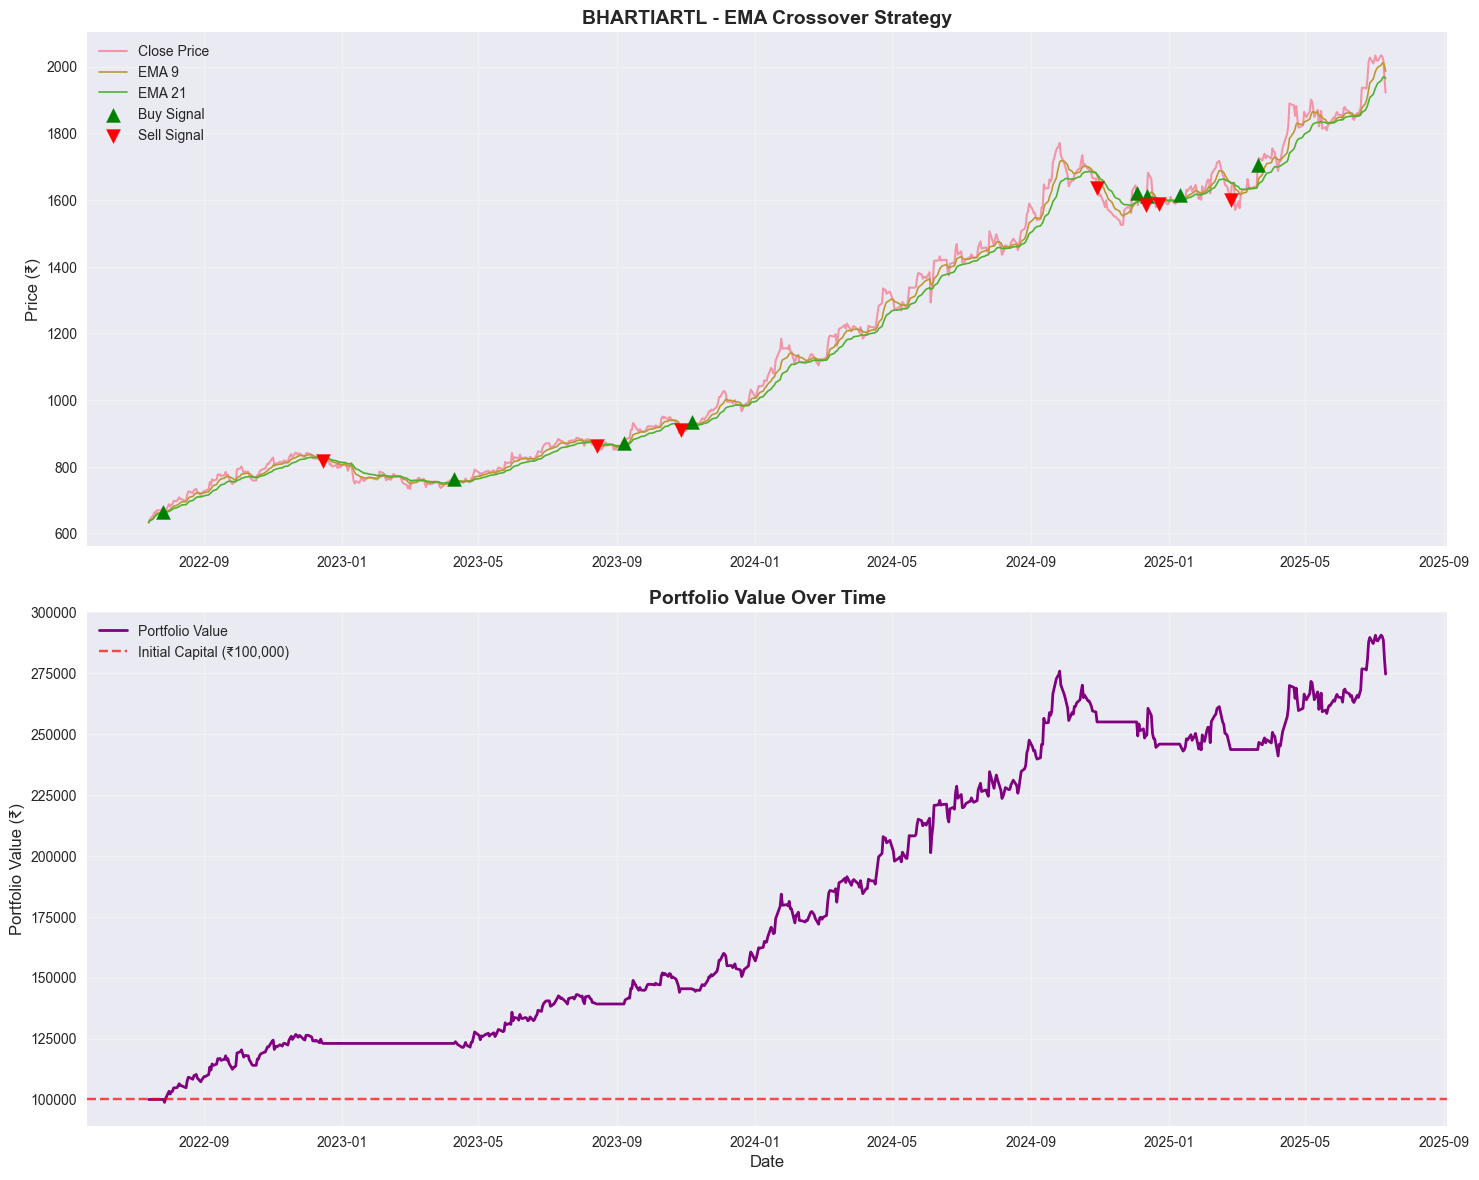


Trade Summary for BHARTIARTL:
Total Trades: 15
Final Portfolio Value: ₹274,509.46
Total Return: 174.51%
Buy & Hold Return: 203.92%


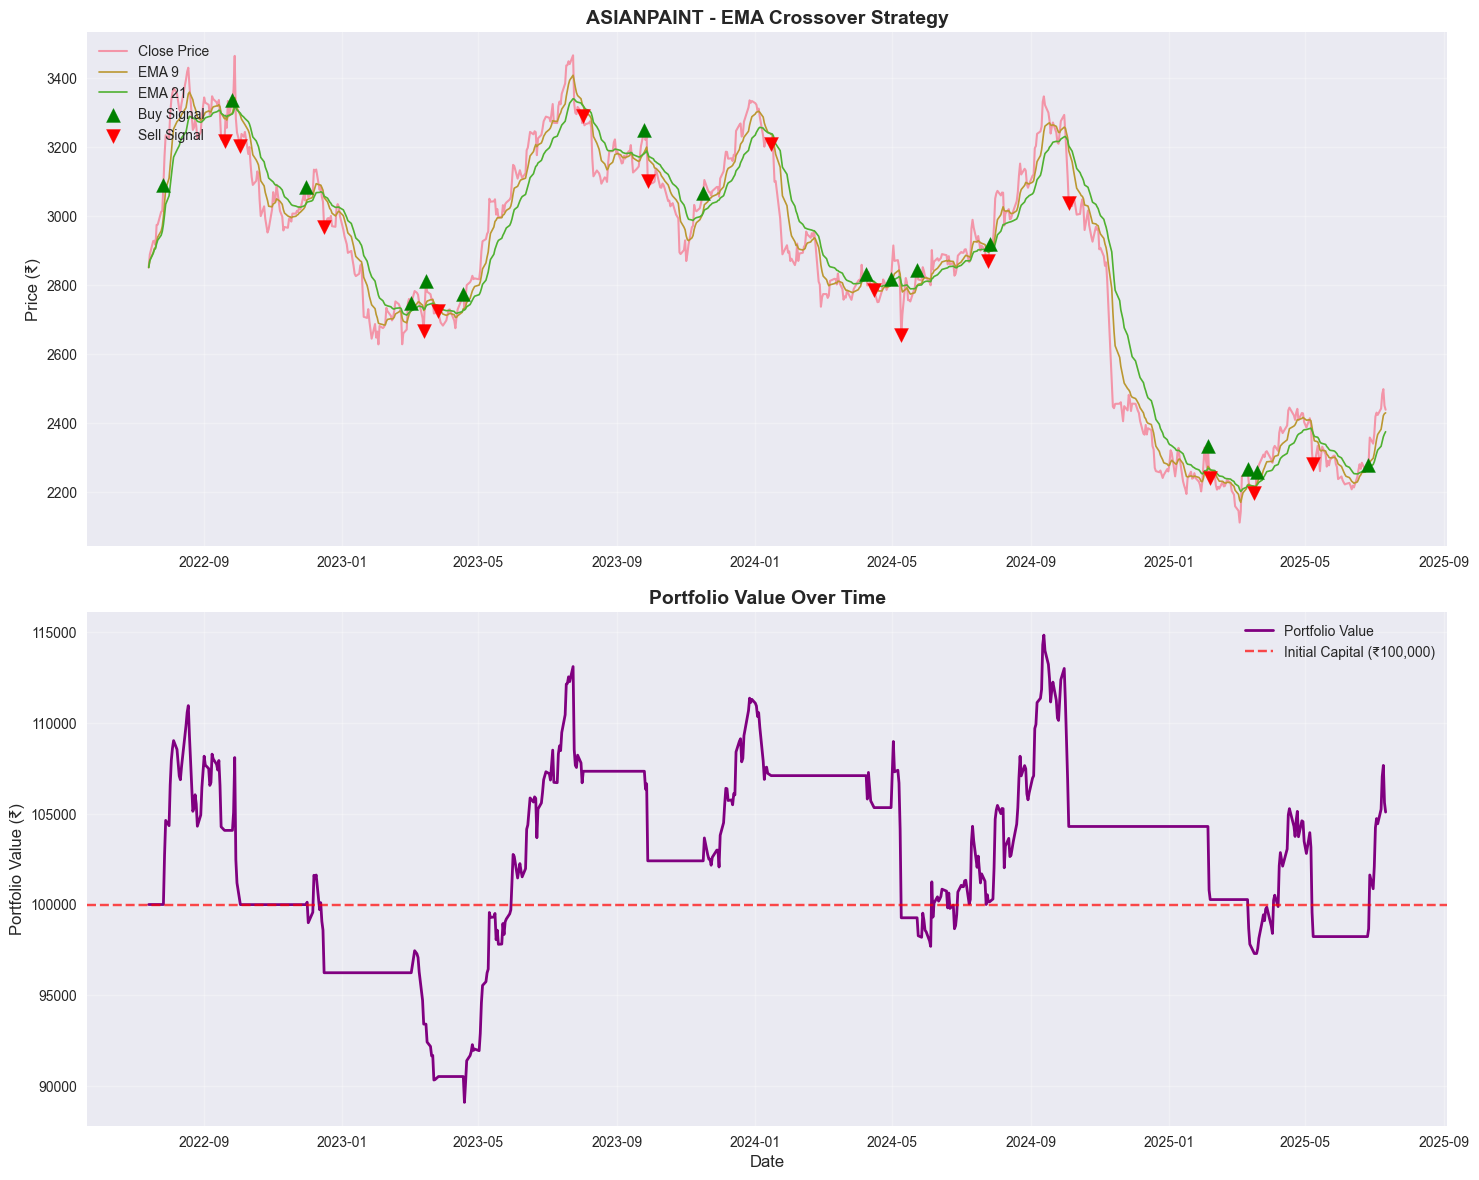


Trade Summary for ASIANPAINT:
Total Trades: 31
Final Portfolio Value: ₹105,095.79
Total Return: 5.10%
Buy & Hold Return: -14.45%


In [10]:
    # Plot charts for all stocks
    for symbol in stock_signals.keys():
        plot_strategy_chart(backtest_results[symbol], symbol, trade_logs[symbol])

In [11]:
# =============================================================================
#  Individual Stock Reports using QuantStats
# =============================================================================

def generate_individual_reports(backtest_results, symbol):
    """
    Generate QuantStats report for individual stock
    """
    data = backtest_results[symbol]
    returns = data['Returns'].dropna()
    
    print(f"\n{'='*60}")
    print(f"QUANTSTATS REPORT FOR {symbol.replace('.NS', '')}")
    print(f"{'='*60}")
    
    # Basic metrics
    print(f"Strategy Performance:")
    print(f"Total Return: {qs.stats.comp(returns):.2%}")
    print(f"Annual Return: {qs.stats.cagr(returns):.2%}")
    print(f"Volatility: {qs.stats.volatility(returns):.2%}")
    print(f"Sharpe Ratio: {qs.stats.sharpe(returns):.2f}")
    print(f"Max Drawdown: {qs.stats.max_drawdown(returns):.2%}")
    print(f"Calmar Ratio: {qs.stats.calmar(returns):.2f}")
    
    # Risk metrics
    print(f"\nRisk Metrics:")
    print(f"VaR (95%): {qs.stats.var(returns):.2%}")
    print(f"CVaR (95%): {qs.stats.cvar(returns):.2%}")
    print(f"Skewness: {qs.stats.skew(returns):.2f}")
    print(f"Kurtosis: {qs.stats.kurtosis(returns):.2f}")
    
    # Win/Loss metrics
    print(f"\nWin/Loss Metrics:")
    print(f"Win Rate: {qs.stats.win_rate(returns):.2%}")
    print(f"Best Day: {qs.stats.best(returns):.2%}")
    print(f"Worst Day: {qs.stats.worst(returns):.2%}")
    
    return returns

# Generate individual reports
individual_returns = {}
for symbol in backtest_results.keys():
    individual_returns[symbol] = generate_individual_reports(backtest_results, symbol)


QUANTSTATS REPORT FOR RELIANCE
Strategy Performance:
Total Return: 9.46%
Annual Return: 3.07%
Volatility: 15.57%
Sharpe Ratio: 0.28
Max Drawdown: -38.60%
Calmar Ratio: 0.08

Risk Metrics:
VaR (95%): -1.60%
CVaR (95%): -2.70%
Skewness: 0.18
Kurtosis: 11.32

Win/Loss Metrics:
Win Rate: 51.22%
Best Day: 7.02%
Worst Day: -7.49%

QUANTSTATS REPORT FOR TCS
Strategy Performance:
Total Return: 18.72%
Annual Return: 5.90%
Volatility: 14.76%
Sharpe Ratio: 0.47
Max Drawdown: -14.35%
Calmar Ratio: 0.41

Risk Metrics:
VaR (95%): -1.50%
CVaR (95%): -2.12%
Skewness: 1.26
Kurtosis: 9.72

Win/Loss Metrics:
Win Rate: 48.70%
Best Day: 6.63%
Worst Day: -4.22%

QUANTSTATS REPORT FOR HDFCBANK
Strategy Performance:
Total Return: 9.69%
Annual Return: 3.14%
Volatility: 16.19%
Sharpe Ratio: 0.28
Max Drawdown: -19.06%
Calmar Ratio: 0.16

Risk Metrics:
VaR (95%): -1.66%
CVaR (95%): -2.79%
Skewness: -1.05
Kurtosis: 12.24

Win/Loss Metrics:
Win Rate: 53.00%
Best Day: 5.67%
Worst Day: -8.44%

QUANTSTATS REPORT FOR 


COMBINED PORTFOLIO ANALYSIS
Total Stocks: 10
Total Initial Capital: ₹1,000,000
Total Final Value: ₹1,325,457.39
Total Return: 32.55%

Combined Portfolio Metrics:
Annual Return: 9.88%
Volatility: 8.41%
Sharpe Ratio: 1.19
Max Drawdown: -13.37%
Calmar Ratio: 0.74


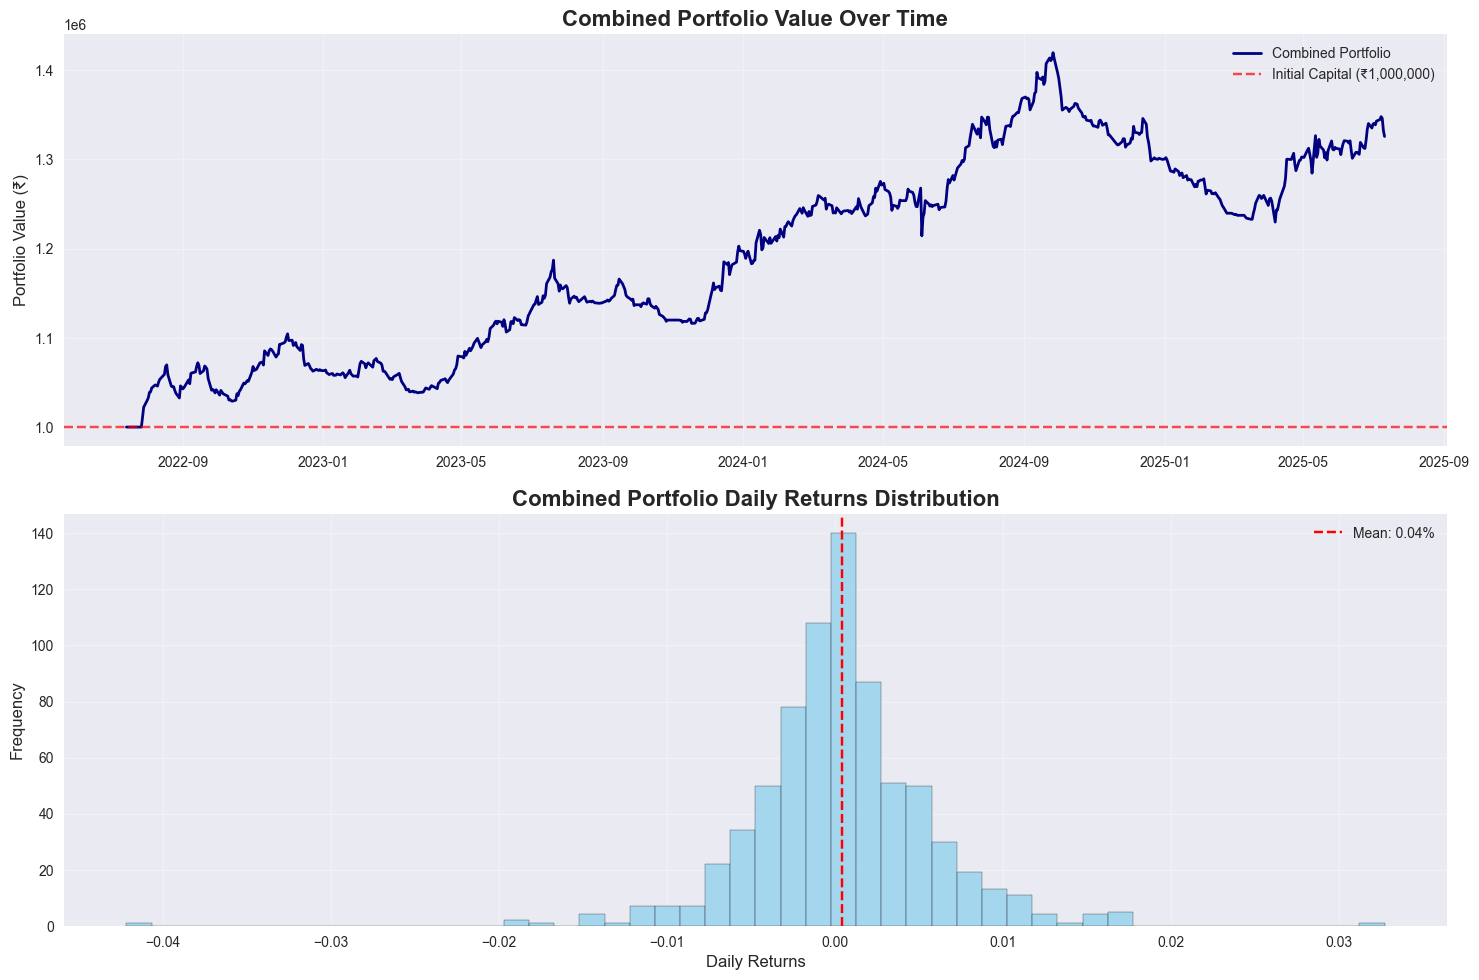

In [14]:
# =============================================================================
#  Combined Portfolio Analysis
# =============================================================================

# Calculate combined portfolio
total_portfolio_value = sum(data['Portfolio_Value'].iloc[-1] for data in backtest_results.values())
total_initial_capital = len(backtest_results) * INITIAL_CAPITAL

print(f"\n{'='*60}")
print(f"COMBINED PORTFOLIO ANALYSIS")
print(f"{'='*60}")

print(f"Total Stocks: {len(backtest_results)}")
print(f"Total Initial Capital: ₹{total_initial_capital:,}")
print(f"Total Final Value: ₹{total_portfolio_value:,.2f}")
print(f"Total Return: {((total_portfolio_value / total_initial_capital - 1) * 100):.2f}%")

# Create combined portfolio dataframe
combined_portfolio = pd.DataFrame(index=list(backtest_results.values())[0].index)
combined_portfolio['Portfolio_Value'] = sum(data['Portfolio_Value'] for data in backtest_results.values())
combined_portfolio['Returns'] = combined_portfolio['Portfolio_Value'].pct_change()

# Combined portfolio metrics
combined_returns = combined_portfolio['Returns'].dropna()

print(f"\nCombined Portfolio Metrics:")
print(f"Annual Return: {qs.stats.cagr(combined_returns):.2%}")
print(f"Volatility: {qs.stats.volatility(combined_returns):.2%}")
print(f"Sharpe Ratio: {qs.stats.sharpe(combined_returns):.2f}")
print(f"Max Drawdown: {qs.stats.max_drawdown(combined_returns):.2%}")
print(f"Calmar Ratio: {qs.stats.calmar(combined_returns):.2f}")

# Plot combined portfolio
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Portfolio value over time
ax1.plot(combined_portfolio.index, combined_portfolio['Portfolio_Value'], 
         linewidth=2, color='navy', label='Combined Portfolio')
ax1.axhline(y=total_initial_capital, color='red', linestyle='--', alpha=0.7,
            label=f'Initial Capital (₹{total_initial_capital:,})')
ax1.set_title('Combined Portfolio Value Over Time', fontsize=16, fontweight='bold')
ax1.set_ylabel('Portfolio Value (₹)', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Returns distribution
ax2.hist(combined_returns.dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax2.axvline(combined_returns.mean(), color='red', linestyle='--', 
            label=f'Mean: {combined_returns.mean():.2%}')
ax2.set_title('Combined Portfolio Daily Returns Distribution', fontsize=16, fontweight='bold')
ax2.set_xlabel('Daily Returns', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
# =============================================================================
#  Performance Summary Table
# =============================================================================

# Create performance summary table
performance_summary = []

for symbol in backtest_results.keys():
    data = backtest_results[symbol]
    returns = data['Returns'].dropna()
    
    performance_summary.append({
        'Stock': symbol.replace('.NS', ''),
        'Initial Capital': f"₹{INITIAL_CAPITAL:,}",
        'Final Value': f"₹{data['Portfolio_Value'].iloc[-1]:,.2f}",
        'Total Return': f"{((data['Portfolio_Value'].iloc[-1] / INITIAL_CAPITAL - 1) * 100):.2f}%",
        'Annual Return': f"{qs.stats.cagr(returns):.2%}",
        'Sharpe Ratio': f"{qs.stats.sharpe(returns):.2f}",
        'Max Drawdown': f"{qs.stats.max_drawdown(returns):.2%}",
        'Volatility': f"{qs.stats.volatility(returns):.2%}",
        'Win Rate': f"{qs.stats.win_rate(returns):.2%}"
    })

# Add combined portfolio row
performance_summary.append({
    'Stock': 'COMBINED',
    'Initial Capital': f"₹{total_initial_capital:,}",
    'Final Value': f"₹{total_portfolio_value:,.2f}",
    'Total Return': f"{((total_portfolio_value / total_initial_capital - 1) * 100):.2f}%",
    'Annual Return': f"{qs.stats.cagr(combined_returns):.2%}",
    'Sharpe Ratio': f"{qs.stats.sharpe(combined_returns):.2f}",
    'Max Drawdown': f"{qs.stats.max_drawdown(combined_returns):.2%}",
    'Volatility': f"{qs.stats.volatility(combined_returns):.2%}",
    'Win Rate': f"{qs.stats.win_rate(combined_returns):.2%}"
})

# Display performance table
performance_df = pd.DataFrame(performance_summary)
print(f"\n{'='*120}")
print("PERFORMANCE SUMMARY TABLE")
print(f"{'='*120}")
print(performance_df.to_string(index=False))


PERFORMANCE SUMMARY TABLE
     Stock Initial Capital   Final Value Total Return Annual Return Sharpe Ratio Max Drawdown Volatility Win Rate
  RELIANCE        ₹100,000   ₹109,461.06        9.46%         3.07%         0.28      -38.60%     15.57%   51.22%
       TCS        ₹100,000   ₹118,718.41       18.72%         5.90%         0.47      -14.35%     14.76%   48.70%
  HDFCBANK        ₹100,000   ₹109,691.65        9.69%         3.14%         0.28      -19.06%     16.19%   53.00%
      INFY        ₹100,000   ₹133,198.70       33.20%        10.06%         0.64      -19.36%     17.88%   51.15%
 ICICIBANK        ₹100,000   ₹126,158.03       26.16%         8.08%         0.59      -14.43%     15.47%   53.25%
HINDUNILVR        ₹100,000   ₹103,168.60        3.17%         1.05%         0.15      -20.48%     13.07%   49.00%
       ITC        ₹100,000   ₹137,172.69       37.17%        11.14%         0.79      -16.96%     15.20%   51.54%
      SBIN        ₹100,000   ₹108,283.01        8.28%        

In [16]:
# =============================================================================
#  Export Results 
# =============================================================================

# Save results to CSV files
print(f"\n{'='*60}")
print("SAVING RESULTS TO CSV FILES")
print(f"{'='*60}")

# Save performance summary
performance_df.to_csv('portfolio_performance_summary.csv', index=False)
print("✓ Performance summary saved to 'portfolio_performance_summary.csv'")

# Save individual stock data
for symbol, data in backtest_results.items():
    filename = f"{symbol.replace('.NS', '')}_backtest_results.csv"
    data.to_csv(filename)
    print(f"✓ {symbol.replace('.NS', '')} results saved to '{filename}'")

# Save combined portfolio
combined_portfolio.to_csv('combined_portfolio_results.csv')
print("✓ Combined portfolio saved to 'combined_portfolio_results.csv'")

print(f"\nStrategy analysis completed successfully!")
print(f"Total execution time: {datetime.now()}")

# =============================================================================
#  Key Insights and Recommendations
# =============================================================================

print(f"\n{'='*60}")
print("KEY INSIGHTS AND RECOMMENDATIONS")
print(f"{'='*60}")

# Calculate some key metrics for insights
best_performer = max(backtest_results.items(), 
                    key=lambda x: x[1]['Portfolio_Value'].iloc[-1])
worst_performer = min(backtest_results.items(), 
                     key=lambda x: x[1]['Portfolio_Value'].iloc[-1])

total_trades = sum(len(log) for log in trade_logs.values())
avg_trades_per_stock = total_trades / len(backtest_results)

print(f" Strategy Overview:")
print(f"   • Strategy: {EMA_SHORT}/{EMA_LONG} EMA Crossover")
print(f"   • Time Period: {START_DATE} to {END_DATE}")
print(f"   • Total Stocks Analyzed: {len(backtest_results)}")
print(f"   • Total Capital Deployed: ₹{total_initial_capital:,}")

print(f"\n Performance Highlights:")
print(f"   • Best Performer: {best_performer[0].replace('.NS', '')} (₹{best_performer[1]['Portfolio_Value'].iloc[-1]:,.2f})")
print(f"   • Worst Performer: {worst_performer[0].replace('.NS', '')} (₹{worst_performer[1]['Portfolio_Value'].iloc[-1]:,.2f})")
print(f"   • Combined Portfolio Return: {((total_portfolio_value / total_initial_capital - 1) * 100):.2f}%")
print(f"   • Average Trades per Stock: {avg_trades_per_stock:.1f}")

print(f"\n Analysis Complete!")


SAVING RESULTS TO CSV FILES
✓ Performance summary saved to 'portfolio_performance_summary.csv'
✓ RELIANCE results saved to 'RELIANCE_backtest_results.csv'
✓ TCS results saved to 'TCS_backtest_results.csv'
✓ HDFCBANK results saved to 'HDFCBANK_backtest_results.csv'
✓ INFY results saved to 'INFY_backtest_results.csv'
✓ ICICIBANK results saved to 'ICICIBANK_backtest_results.csv'
✓ HINDUNILVR results saved to 'HINDUNILVR_backtest_results.csv'
✓ ITC results saved to 'ITC_backtest_results.csv'
✓ SBIN results saved to 'SBIN_backtest_results.csv'
✓ BHARTIARTL results saved to 'BHARTIARTL_backtest_results.csv'
✓ ASIANPAINT results saved to 'ASIANPAINT_backtest_results.csv'
✓ Combined portfolio saved to 'combined_portfolio_results.csv'

Strategy analysis completed successfully!
Total execution time: 2025-07-13 08:56:46.945210

KEY INSIGHTS AND RECOMMENDATIONS
 Strategy Overview:
   • Strategy: 9/21 EMA Crossover
   • Time Period: 2022-07-14 to 2025-07-13
   • Total Stocks Analyzed: 10
   • Tota

# Future Scope for Improvement and Live Automated Deployment

In [17]:
# Once real-time data is available, the same EMA crossover logic can be implemented 
# for live trading using Zerodha Kite Connect API with the following approach:

# Kite Connect Setup - Initialize API connection
# Real-time Data - Stream live price data using WebSocket
# Signal Generation - Same EMA crossover logic with real-time data
# Automated Execution - Place buy/sell orders automatically
# Risk Management - Position sizing and stop-loss implementation
